# Regression

Let's look at some examples of regression calculations in Python.  I haven't found any direct equivalent to `regress` from Matlab's statistical toolbox.  Similar functionality is available in the Python [statsmodels](http://statsmodels.org) package.  I will give an example of its use below, but we will also see how to calculate the things we need without it.

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as ss
from scipy import linalg  # numpy linalg plus extras
import statsmodels.api as sm

from pycurrents.system import Bunch

## Simple regression, straight line

First we will illustrate a single straight-line fit using random data to make partially correlated variables.  We will use a function from scipy.stats, `linregress`.

<IPython.core.display.Javascript object>


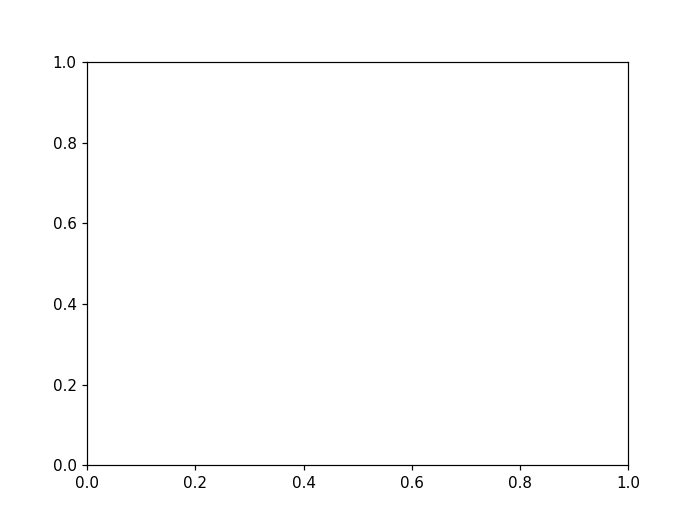

In [23]:
ny = 100 
b_true = 0.5
x1 = np.random.randn(ny) # signal
epsilon = np.random.randn(ny) # noise
y = b_true * x1 + epsilon

fig,(ax0, ax1) = plt.subplots(2)
t=np.linspace(0,10,ny)
ax0.plot(t,y,t,x1)
ax1.plot(y,x1,'o')
line=np.linspace(y.min(),y.max(),3)
ax1.plot(line,line,'k:')
ax1.set_aspect('equal')

In [24]:
slope, intercept, r, p, stderr = ss.linregress(x1, y)
print("slope:", slope, " intercept:", intercept, 
      " r:", r, " p:", p, " stderr:", stderr)
ax1.plot(0,intercept,'r*')
liney=line*slope+intercept;
ax1.plot(line,liney,'r-')

slope: 0.496688691505828  intercept: -0.1819956681573225  r: 0.4729844426585307  p: 6.721494787536857e-07  stderr: 0.09346202273324902


<IPython.core.display.Javascript object>


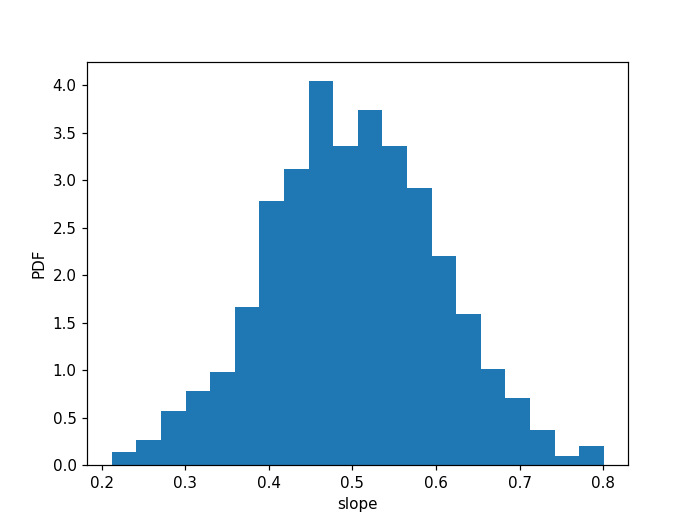

Text(0.5, 0, 'slope')

In [43]:
# Exercise: put this in a loop and collect the statistical distribution of the slope from many realizations.
nreal=1000
store_slope=[]
# np.vstack?
for r in range(nreal):
    ny = 100 
    b_true = 0.5
    x1 = np.random.randn(ny) # signal
    epsilon = np.random.randn(ny) # noise
    y = b_true * x1 + epsilon
    slope, intercept, r, p, stderr = ss.linregress(x1, y)
    store_slope=np.hstack((store_slope,slope))
fig,ax = plt.subplots()
ax.hist(store_slope,20,density=True)
ax.set_ylabel('PDF')
ax.set_xlabel('slope')

The slope from the fit is reasonably close to its "true" value, `b_true`; and the intercept is near zero.

Exercise: put this in a loop and collect the statistical distribution of the slope from many realizations.

Linear regression with just a mean and a slope is so simple that we can easily do it in a vectorized way, so that we can do it efficiently for large numbers of series at once.  Let's make a function to do it for something like regressing SST at many locations on the SOI.  We will illustrate again with fake data.


Here is the function.  Note that it is designed to work with y being 1-D or higher, and with any location of the time axis.  (We don't need scipy.stats for this, just numpy.)

In [44]:
def regress_many(x, y, axis=0):
    """
    Regress y on x.

    x is a 1-D array or masked array with n points.
    y is at least 1-D, with n points along the dimension
    specified by axis.

    Returns (b1, r), where b1 is the slope and r is the correlation
    coefficient.
    """
    # Allow masked arrays and ordinary arrays, and remove the means.
    x = np.asanyarray(x)
    x -= x.mean()
    y = np.asanyarray(y)
    y -= y.mean(axis=axis, keepdims=True)
    
    # Black magic to accomodate any dimensionality of y:
    bc = tuple([slice(None) if i == axis else np.newaxis 
               for i in range(y.ndim)])
    
    # Note that we need only sums of squares and products.
    Sxx = (x**2).sum()
    Syy = (y**2).sum(axis=axis)
    Sxy = (x[bc] * y).sum(axis=axis)
    
    r = Sxy / np.ma.sqrt(Sxx * Syy)
    b1 = Sxy / Sxx
    
    return b1, r

Let's test the new function. First, verify that it gives the same result as `linregress` on the simple 1-D example:

In [45]:
b1, r = regress_many(x1, y)
print(b1)
print(r)

0.465326007261699
0.38232455163579815


Now, make some 2-D data, simulating a common calculation in oceanography and meteorology: looking at the correlation between a scalar time series, such as the Southern Oscillation Index, and a time series of maps, such as a satellite-based estimate of sea-surface temperature.  In this simulation we are not trying to make anything look like the SOI or SST, but we are making simple arrays with the corresponding dimensions, so we could later plug in an actual SOI time series and set of SST maps.

In [46]:
# fake data for testing
npts = 100
nlon = 121
nlat = 81
lon = np.linspace(140, 260, nlon)
lat = np.linspace(-40, 40, nlat)

# Very unrealistic: uncorrelated random points
SOI = np.random.randn(npts)

# Very unrealistic: partial correlation, as in the earlier example
# Here is the noise part:
SST = np.random.randn(npts, nlon, nlat)
# Now let's give the correlated part some spatial structure:
amp = 1 + (lon[:, np.newaxis] - 140) / 120  + lat / 40
SST += amp * SOI[:, np.newaxis, np.newaxis]
# The correlation now ramps up from SW to NE.


In [47]:
b1, r = regress_many(SOI, SST)

print(b1.shape, r.shape)
print(b1.min(), b1.mean(), b1.max())
print(r.min(), r.mean(), r.max())

(121, 81) (121, 81)
-0.22413311078407452 1.497848928098117 3.2067993558065755
-0.20348749104172814 0.7583132566086026 0.9592735133996557


Now we will use filled contours to plot the slope and the correlation coefficient.

<IPython.core.display.Javascript object>


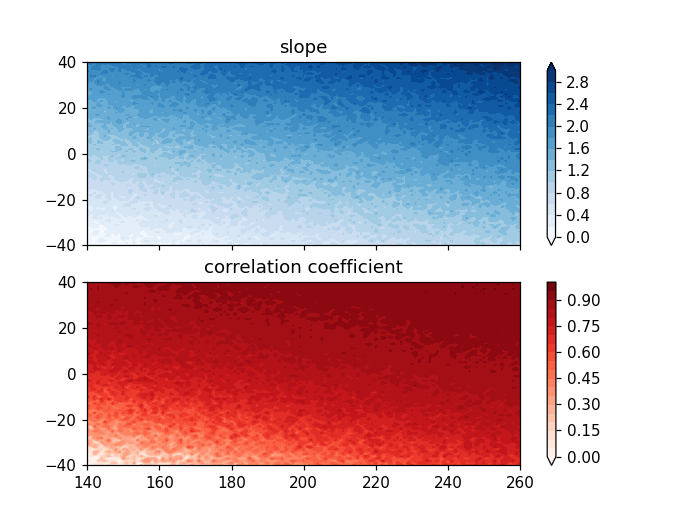

Text(0.5, 1.0, 'correlation coefficient')

In [52]:
fig, axs = plt.subplots(nrows=2, sharex=True)
ax = axs[0]
slopelevs = np.arange(0, 3.01, 0.2)
# Notice that because the arrays here have dimensions nlon, nlat,
# we have to transpose them so that they will be contoured with
# the right orientation.
cmap1 = plt.get_cmap('Blues')
cs1 = ax.contourf(lon, lat, b1.T, levels=slopelevs, 
                  cmap=cmap1, extend='both')
cbar1 = fig.colorbar(cs1, ax=ax)
ax.set_title('slope')

ax = axs[1]
rlevs = np.arange(0, 1.01, 0.05)
cmap2 = plt.get_cmap('Reds')
cs2 = ax.contourf(lon, lat, r.T, levels=rlevs, cmap=cmap2,
                   extend='min')
cbar2 = fig.colorbar(cs2, ax=ax)
ax.set_title('correlation coefficient')



<IPython.core.display.Javascript object>


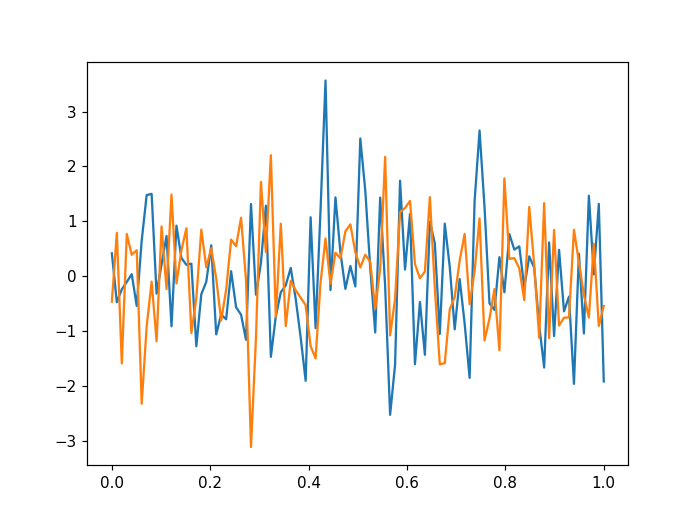

In [55]:
# KD plot the data at one location as a timeseries 
fig,ax = plt.subplots()
t=np.linspace(0,1,npts)
ax.plot(t,SST[:,1,1],t,SOI)

What happens if we let the "SST" be a uniform multiple of "SOI", but with the added noise component ramped up from SW to NE?

<IPython.core.display.Javascript object>


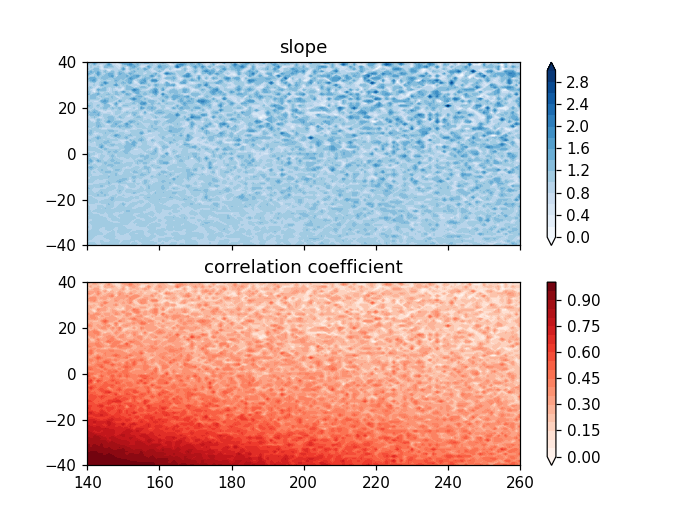

Text(0.5, 1.0, 'correlation coefficient')

In [56]:
SST = SOI[:, np.newaxis, np.newaxis] # uniform multiple
SST = SST + 2 * amp * np.random.randn(npts, nlon, nlat) # plus noise ramp

b1, r = regress_many(SOI, SST)

fig, axs = plt.subplots(nrows=2, sharex=True)
ax = axs[0]
slopelevs = np.arange(0, 3.01, 0.2)

cmap1 = plt.get_cmap('Blues')
cs1 = ax.contourf(lon, lat, b1.T, levels=slopelevs, 
                  cmap=cmap1, extend='both')
cbar1 = fig.colorbar(cs1, ax=ax)
ax.set_title('slope')

ax = axs[1]
rlevs = np.arange(0, 1.01, 0.05)
cmap2 = plt.get_cmap('Reds')
cs2 = ax.contourf(lon, lat, r.T, levels=rlevs, cmap=cmap2,
                   extend='min')
cbar2 = fig.colorbar(cs2, ax=ax)
ax.set_title('correlation coefficient')

## Multiple linear regression

The basic MLR calculation is easily done, as will be illustrated here.  The following model could be considered as a starting point for fitting a diurnal cycle, or an annual cycle, for example.

We will first make a fake data set with a deterministic part and a random part.  The deterministic part consists of a mean and a sinusoid (which has a sine part and a cosine part).  We could add a zero-mean trend; that is left as an exercise.

<IPython.core.display.Javascript object>


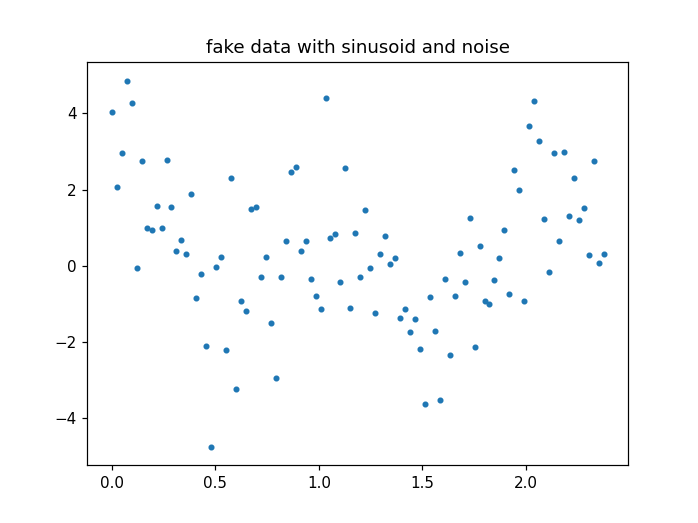

Text(0.5, 1.0, 'fake data with sinusoid and noise')

In [57]:
ny = 100
# frequency in cycles per time unit:
freq = 1

t = np.linspace(0, 2.4, ny, endpoint=False)

xc = np.cos(2 * np.pi * freq * t)
xs = np.sin(2 * np.pi * freq * t)

ys = 0.5      # amp of sine component
yc = 1.2      # amp of cosine component
y0 = 0.2      # mean
yrand = 1.5   # amp of Gaussian noise

np.random.seed(0)  # make the "random" numbers repeatable
y = y0 + yc * xc + ys * xs + yrand * np.random.randn(ny)

fig, ax = plt.subplots()
ax.plot(t, y, '.')
ax.set_title('fake data with sinusoid and noise')


Now make the model.  Note that we know the frequency of the sinusoid; only its amplitude and phase, or equivalently its cosine and sine coefficients, need to be determined by the fit.  If we did not know the frequency, we could not use linear regression at all; it would be a fundamentally nonlinear problem.  (Also, note that it is linear in the sine and cosine coefficients, but *not* in amplitude and phase; that's why we solve for the former, from which we can calculate the latter.)

Each column in the $X$ array is the time series of one component of the model.  Here we have 3 components; the first one is all ones, so its coefficient will be the mean.

<IPython.core.display.Javascript object>


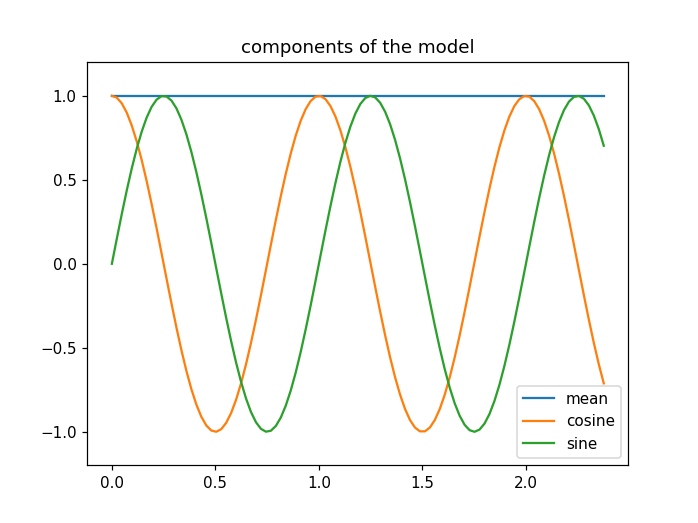

Text(0.5, 1.0, 'components of the model')

In [58]:
nparams = 3  # parameters in the model
xmod = np.ones((ny, nparams), dtype=float)
xmod[:,1] = xc
xmod[:,2] = xs

fig, ax = plt.subplots()
ax.plot(t, xmod)  # plots columns of xmod versus t
ax.set_ylim(-1.2, 1.2)
ax.legend(['mean', 'cosine', 'sine'])
ax.set_title('components of the model')

Next we find the least-squares solution of $Y = X b $ , the fit based on that solution, and the residuals from the fit:

b is:  [0.25006954 1.40301451 0.756066  ]


<IPython.core.display.Javascript object>


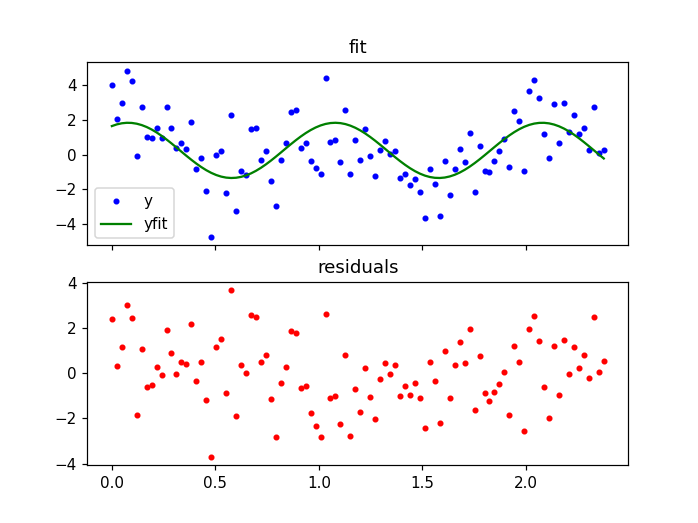

Text(0.5, 1.0, 'residuals')

In [60]:
b = linalg.lstsq(xmod, y)[0] # ignore other outputs
yfit = np.dot(xmod, b)
# yfit = xmod @ b  # New matrix-multiplication operator...
yresid = y - yfit

print("b is: ", b)

fig, axs = plt.subplots(nrows=2, sharex=True)
axs[0].plot(t, y, 'b.', t, yfit, 'g-')
axs[0].legend(['y', 'yfit'], loc='best')
axs[0].set_title('fit')

axs[1].plot(t, yresid, 'r.')
axs[1].set_title('residuals')

We can also calculate the uncertainties in the parameters.  This will depend on the variance-covariance matrix of the model.  In this context, "variance" and "covariance" is really referring just to sums of products; the means are not removed, and there is no normalization by the number of points.

In [74]:
# dot() does matrix multiplication
# vcv_mod = np.dot(xmod.T, xmod)
vcv_mod = xmod.T @ xmod
print(vcv_mod)

[[100.           4.79499138  11.67978251]
 [  4.79499138  48.60799289   1.37462363]
 [ 11.67978251   1.37462363  51.39200711]]


Notice that the matrix is symmetric, and that the off-diagonal elements are substantial; this means that the columns in our model are not independent.  This is typically the case, and doesn't hurt, so long as the correlations are fairly small.  When columns are highly correlated, however, it means that the coefficients will be poorly determined and highly uncertain.

The variance-covariance matrix for the estimated parameters is 
$$V(b) = (X'X)^{-1}\sigma^2$$
where $\sigma^2$ is the variance of $\epsilon$, *assuming* the $\epsilon$ distribution is *uniform* and **independent**; that is, the variance-covariance matrix of $\epsilon$ is $\sigma^2$ on the diagonal and zero off the diagonal.  We estimate $\sigma^2$ from the residuals, compensating for the 3 DOF removed by this model with its 3 components.  The numpy `var()` function has a kwarg for this.  

In [75]:
epsvar = np.var(yresid, ddof=nparams)
bvar = linalg.inv(vcv_mod) * epsvar
print('Estimated variance of epsilon:', epsvar)
print('\nVCV matrix for the coefficients, b:')
print(bvar)
print('\nEstimated std dev of epsilon:')
print(np.sqrt(epsvar))
print('versus true value:')
print(yrand)

Estimated variance of epsilon: 2.3010524259519842

VCV matrix for the coefficients, b:
[[ 0.02373887 -0.00219083 -0.0053365 ]
 [-0.00219083  0.047577   -0.00077467]
 [-0.0053365  -0.00077467  0.04600806]]

Estimated std dev of epsilon:
1.5169220236887537
versus true value:
1.5


Our estimated variance of $\epsilon$ is very close to the value we used to generate it.

The standard deviations of the parameter estimates are just the square roots of the diagonal entries:

In [76]:
bstd = np.sqrt(np.diag(bvar))
print(bstd)

[0.15407422 0.21812152 0.21449489]


The off-diagonal elements of bvar show how errors in one parameter are coupled with errors in another.  For example, the correlation coefficients between the sine and cosine parameters, and the sine and mean, are:

In [77]:
print(bvar[1, 2] / (bstd[1] * bstd[2]))
print(bvar[0, 2] / (bstd[0] * bstd[2]))

-0.016557818231182554
-0.1614764604308733


We see that the sine and cosine components are nearly orthogonal, but a positive error in the sine coefficient will tend to occur together with a negative error in the mean.

I think that at this point, treating the standard deviations of the parameters as Gaussian with the standard deviation estimated above is good enough; then you can just use two standard deviations, or whatever you like.  But technically we should use the t distribution, so let's try it. (Recall that the t distribution is similar to the Gaussian, but it has heavier tails to take into account the fact that don't know the true standard deviation, but must instead estimate it from the data.)

In [78]:
b_t = ss.t(ny - nparams, loc=b, scale=bstd)
b_lo = b_t.ppf(0.025)
b_hi = b_t.ppf(0.975)
print(b_lo)
print(b)
print(b_hi)

[-0.05572514  0.97010368  0.33035302]
[0.25006954 1.40301451 0.756066  ]
[0.55586422 1.83592535 1.18177898]


Doing this manually was not so hard, but let's try out a fancy function from statsmodels, a higher-powered statistical package.

In [79]:
model = sm.OLS(y, xmod)
results = model.fit()
print(results.summary())  # makes a formatted table

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     27.28
Date:                Mon, 28 Dec 2020   Prob (F-statistic):           3.98e-10
Time:                        17:14:57   Log-Likelihood:                -182.04
No. Observations:                 100   AIC:                             370.1
Df Residuals:                      97   BIC:                             377.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2501      0.154      1.623      0.1

That's more than we wanted to know!  Let's isolate the bits we care about.  The documentation is sparse, so we have to do a little exploration.  Let's see what's available.

In [80]:
print(dir(results))

['HC0_se', 'HC1_se', 'HC2_se', 'HC3_se', '_HCCM', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abat_diagonal', '_cache', '_data_attr', '_data_in_cache', '_get_robustcov_results', '_is_nested', '_use_t', '_wexog_singular_values', 'aic', 'bic', 'bse', 'centered_tss', 'compare_f_test', 'compare_lm_test', 'compare_lr_test', 'condition_number', 'conf_int', 'conf_int_el', 'cov_HC0', 'cov_HC1', 'cov_HC2', 'cov_HC3', 'cov_kwds', 'cov_params', 'cov_type', 'df_model', 'df_resid', 'diagn', 'eigenvals', 'el_test', 'ess', 'f_pvalue', 'f_test', 'fittedvalues', 'fvalue', 'get_influence', 'get_prediction', 'get_robustcov_results', 'initialize', 'k_constant', 'llf', 'load', 'model', 'mse_model', 'mse_resid'

It turns out we need an attribute, `params`, and a method, `conf_int`:

In [81]:
print('Parameters (b):')
print(results.params)
print('\nConfidence intervals:')
print(results.conf_int(alpha=0.05).T)

Parameters (b):
[0.25006954 1.40301451 0.756066  ]

Confidence intervals:
[[-0.05572514  0.97010368  0.33035302]
 [ 0.55586422  1.83592535  1.18177898]]


## A function for MLR

Let's make a function that efficiently calculates the MLR parameters and their confidence intervals for a time series as a function of depth--that is, for a 2-D array.  The key to doing this efficiently is noticing that only the last steps involve the depth dimension.  We won't need to use a loop at all; everything will be vectorized.  We will use functions to calculate $(X'X)^{-1}$, which we need for the confidence limits, and $(X'X)^{-1}X'$, which is known as the pseudoinverse of $X$.  If our time series, $Y$, is arranged with ntimes rows and ndepths columns, then matrix-multiplying this times the pseudoinverse gives us the parameters, $b$, with one column for each depth.

In [84]:
def mlr(y, x, alpha=0.05):
    """
    Multiple linear regression.
    
        y: 1-D or 2-D array, independent variable.
            (ntimes,) or (ntimes, nrealizations)
        x: 2-D array, model; (ntimes, nparams)
    
    returns a Bunch with attributes:
    
        y: the input dependent variable
        x: the input model
        alpha: the input confidence level
        b: (nparams,) or (nparams, nrealizations)
        b_std: standard error of b
        b_lo: lower confidence limits
        b_hi: upper confidence limits
        fit: same shape as y
        residuals: same shape as y
        
    The input arrays must be ndarrays with no nan or inf values; 
    masked arrays are not supported.

    """
    ntimes, nparams = x.shape
    if y.shape[0] != ntimes:
        raise ValueError("Shape mismatch: x is %s, y is %s" %
                         x.shape, y.shape)
    pinv = linalg.pinv2(x)
    b = np.dot(pinv, y)
    fit = np.dot(x, b)
    residuals = y - fit
    
    eps_std = np.std(residuals, axis=0, ddof=nparams, keepdims=True)
    inv_vcv = linalg.inv(np.dot(x.T, x))
    b_std = (np.sqrt(np.diag(inv_vcv)) * eps_std.T).T
    b_t = ss.t(ntimes - nparams, loc=b, scale=b_std)
    b_lo = b_t.ppf(alpha/2)
    b_hi = b_t.ppf(1 - alpha/2)
    out = Bunch(x=x, y=y, b=b, b_std=b_std, b_lo=b_lo,
                b_hi=b_hi, fit=fit, residuals=residuals)
    return out

Test it first with the same time series we used above:

In [88]:
test1 = mlr(y, xmod)
print(test1.b_lo)
print(test1.b)
print(test1.b_hi)

[-0.05572514  0.97010368  0.33035302]
[0.25006954 1.40301451 0.756066  ]
[0.55586422 1.83592535 1.18177898]


Now try a minimal test with a 2-D array by making two columns of y:

In [89]:
y2 = np.column_stack((y, y))
test2 = mlr(y2, xmod)
print(test2.b)
attributes = sorted(list(test2.keys()))
print("shapes:")
for a in attributes:
    print("%12s : %12s" % (a, test2[a].shape))

[[0.25006954 0.25006954]
 [1.40301451 1.40301451]
 [0.756066   0.756066  ]]
shapes:
           b :       (3, 2)
        b_hi :       (3, 2)
        b_lo :       (3, 2)
       b_std :       (3, 2)
         fit :     (100, 2)
   residuals :     (100, 2)
           x :     (100, 3)
           y :     (100, 2)


Last, test with a larger array.  To keep things simple, only the random component will vary from one column to the next.  This also lets us do an empirical test of the estimated parameter error bars.

In [ ]:
def make_test_array(ntimes=100, ncolumns=1000,
                    y0=0.2, yc=1.2, ys=0.5, yrand=1,
                    seed=0):

    # frequency in cycles per time unit:
    freq = 1

    t = np.linspace(0, 10, ntimes)

    xc = np.cos(2 * np.pi * freq * t)
    xs = np.sin(2 * np.pi * freq * t)

    xmod = np.ones((ntimes, 3), float)
    xmod[:, 1] = xc
    xmod[:, 2] = xs
    
    np.random.seed(seed)  # make the "random" numbers repeatable
    y = y0 + yc * xc + ys * xs
    y = y[:, np.newaxis] + yrand * np.random.randn(ntimes, ncolumns)
    return y, xmod


In [ ]:
yy, xmod = make_test_array(yrand=4, ntimes=10000, seed=20)
bigtest = mlr(yy, xmod)
print(bigtest.b.mean(axis=-1))
print(bigtest.b.std(axis=-1))
print(bigtest.b_std.mean(axis=-1))

That looks fine.  Notice that the mean of the estimated standard deviations (third line) is close to the actual standard deviation over the ensemble of trials (second line).

In [ ]:
fig, ax = plt.subplots()
counts, edges, patches = ax.hist(bigtest.b[0], bins=20, density=True)
ax.set_xlabel('constant term in the MLR')
ax.set_ylabel('PDF')

The mlr function above has one limitation: it can't handle missing data.  If your data set has missing points--that is, for a given column in $Y$, there are times with nan or a masked value--then the corresponding rows in the $X$ array must be deleted before calculating the inverse and the pseudo-inverse.  There are two ways of dealing with this: either interpolate to replace the bad values in $Y$, after which the mlr function can be used on the whole array, or use a loop to cycle through the columns of $Y$, using indexing to remove the bad points and the corresponding rows of $X$, and applying the mlr function with each 1-dimensional cleaned $Y$ and its matching $X$. The results of these two methods will be similar if the data gaps are small and not too numerous, but interpolation will bias the error estimates low.  If large chunks of data are missing, one should use the slower loop strategy.

In [ ]:
def mlr_gappy(y, x, alpha=0.05):
    """
    MLR; handles y as a masked array or with nans.
    x must still be an ndarray with all valid values.
    See mlr() docstring for details.
    """
    ma_input = np.ma.isMA(y)
    ym = np.ma.masked_invalid(y)
    # If there are no bad values call mlr directly,
    # ensuring y is an ndarray and not a masked array.
    if not np.ma.is_masked(ym):
        return mlr(ym.filled(), x, alpha=alpha)
    
    if y.ndim == 1:
        igood = ~ym.mask  # True where not masked.
        result = mlr(ym[igood].filled(), x[igood], alpha=alpha)
        
        resid = ym.copy()
        resid[igood] = result.residuals
        result.residuals = resid
        
        fit = ym.copy()
        fit[igood] = result.fit
        result.fit = fit
        
        if not ma_input:
            for key in ('fit', 'residuals'):
                result[key] = result[key].filled(np.nan)
        
        return result

    # 2-D case, with time as the first axis
    nseries = y.shape[1]
    ntimes, nparams = x.shape

    bshape = (nparams, nseries)
    b = np.empty(bshape)
    b_lo = np.empty(bshape)
    b_hi = np.empty(bshape)
    b_std = np.empty(bshape)
    fit = np.nan + np.zeros(y.shape)
    residuals = np.nan + np.zeros(y.shape)
    
    out = Bunch(b=b, b_lo=b_lo, b_hi=b_hi, b_std=b_std, 
                fit=fit, residuals=residuals)
    
    for i in range(nseries):
        yi = ym[:, i]
        igood = ~yi.mask
        result = mlr(yi[igood].filled(), x[igood])
        for key in ('b', 'b_lo', 'b_hi', 'b_std'):
            out[key][:, i] = result[key]
        for key in ('fit', 'residuals'):
            out[key][igood, i] = result[key]
    
    if ma_input:
        for key in ('fit', 'residuals'):
            out[key] = np.ma.masked_invalid(out[key])
            
    out.x = x
    out.y = y
    
    return out


Test with gappy data.  Because of its need to loop, this function will be slow, so don't try it with a large number of input columns.

In [ ]:
yy, xmod = make_test_array()
# make a Boolean array with 1/3 of its values
#   True, randomly distributed.
ibad = np.random.randint(3, size=yy.shape) > 1
yyb = yy.copy()
yyb[ibad] = np.nan
bigtest = mlr_gappy(yyb, xmod)
print('With gaps:')
print(bigtest.b.mean(axis=-1))
print(bigtest.b.std(axis=-1))
print(bigtest.b_std.mean(axis=-1))

bigtestng = mlr(yy, xmod)
print('\nWithout gaps:')
print(bigtestng.b.mean(axis=-1))
print(bigtestng.b.std(axis=-1))
print(bigtestng.b_std.mean(axis=-1))


Based on this very minimal testing, it appears the function works.  